<a href="https://colab.research.google.com/github/vkt1414/mhubai-unleashed/blob/main/src/radiomics_notebook/mhub_dicomsegAndRadiomicsSR_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook generates DICOM Seg objects and DICOM Structured Reports with Segmentation Maps and the corresponding csv manifest containing the download urls to CT DICOM files as the input**

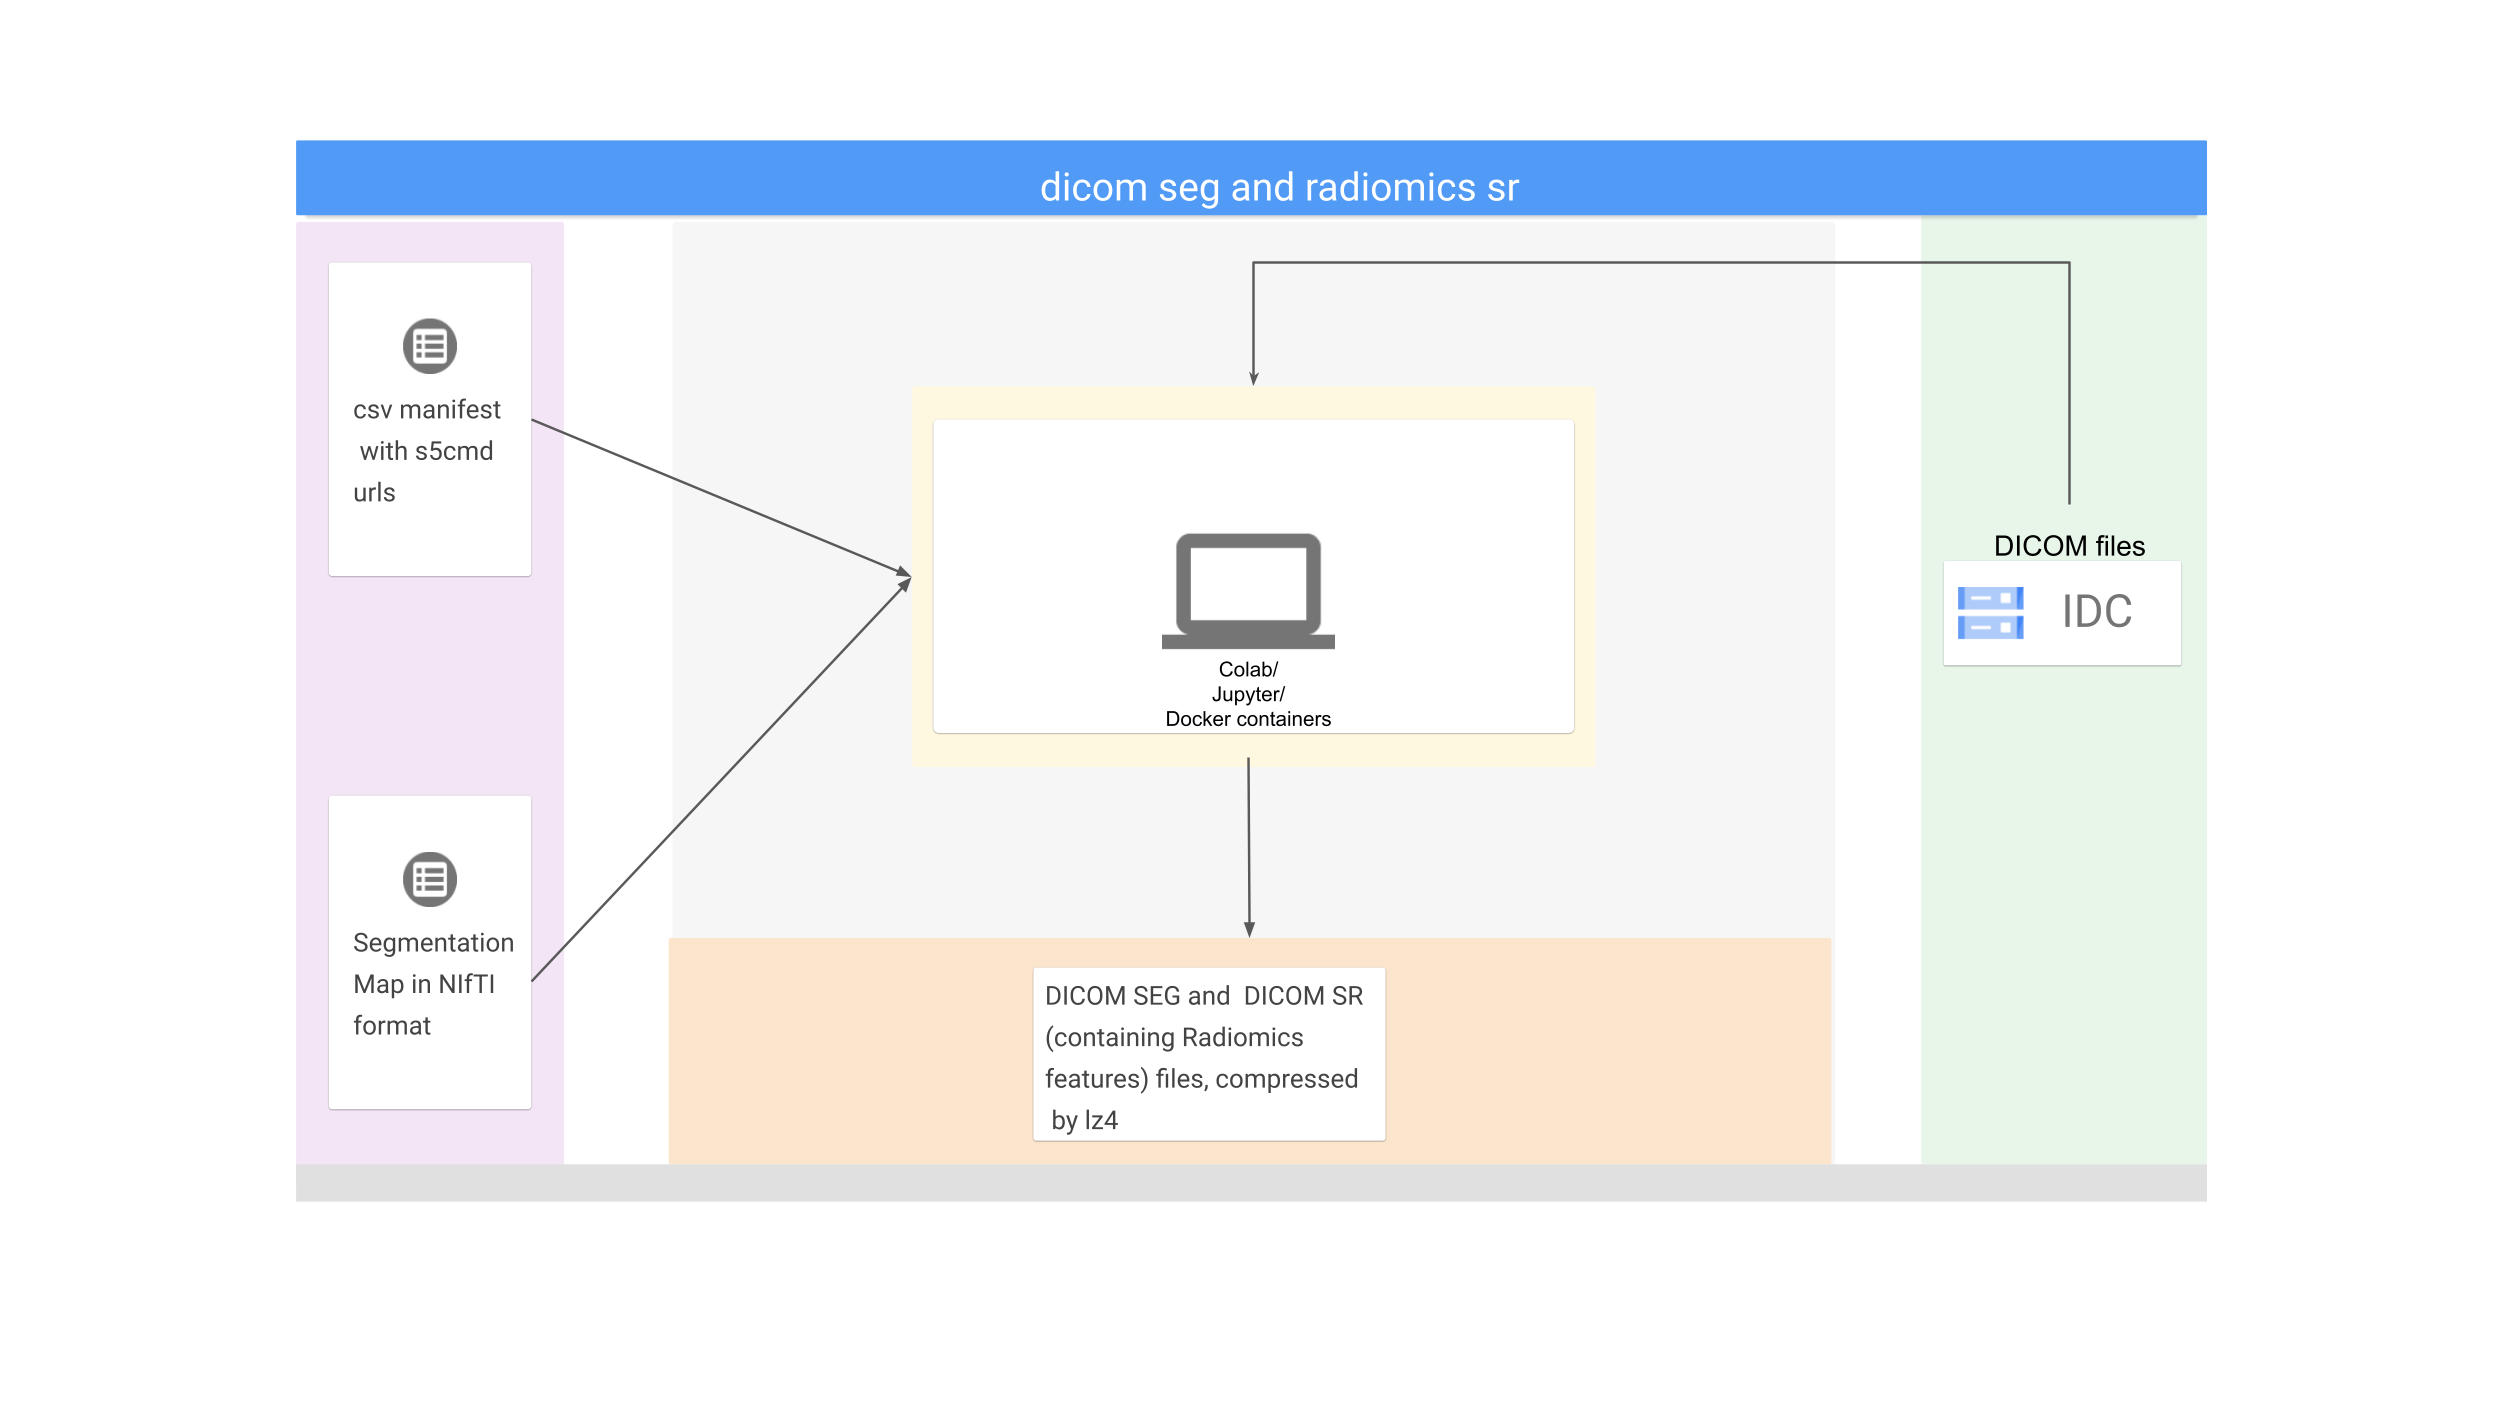

Please cite:

Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S., Aerts, H. J. W. L., Homeyer, A., Lewis, R., Akbarzadeh, A., Bontempi, D., Clifford, W., Herrmann, M. D., Höfener, H., Octaviano, I., Osborne, C., Paquette, S., Petts, J., Punzo, D., Reyes, M., Schacherer, D. P., … Kikinis, R. (2021). NCI Imaging Data Commons. Cancer research, 81(16), 4188–4193. https://doi.org/10.1158/0008-5472.CAN-21-0950

Expected file directory
```
Inference
 └─── $series_id_1
       ├─── $SEG_NIfTI.nii.lz4
       │
 └───  $series_id_2
       ├─── $SEG_NIfTI.nii.lz4
       ├───  ...
       │
 └───  $series_id_n
       └─── $SEG_NIfTI.nii.lz4

```

##**Ways to utilize this notebook**


*   **Colab**
*   **Jupyter Notebook/Lab**
*   **DockerContainer/Terra/SB-CGC**


####**Colab**
*  This notebook was initally developed and tested on Colab, and a working version is saved on github
*  To run this notebook with Colab, Click 'Open In Colab' icon on top left 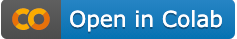
*Uncomment all the cells under "Installing Packages"
*Provide the path to lz4 compressed file containing Segmentation NIfTI files as shown 'Expected file directory' under "Parameters for Papermill"
*Provide the path to csv manifest containing corresponding SeriesInstanceUID and s5cmd download urls (specific to IDC aws buckets) under "Parameters for Papermill"
* A sample file containing the segmentation maps and corresponding csv manifest is provided for convenience can be downloaded by uncommenting and running the cells in "For local testing"
* The CSV manifest expects a SeriesInstanceUID and s5cmd url to download the entire series. The manifest may contain any other metadata if needed.
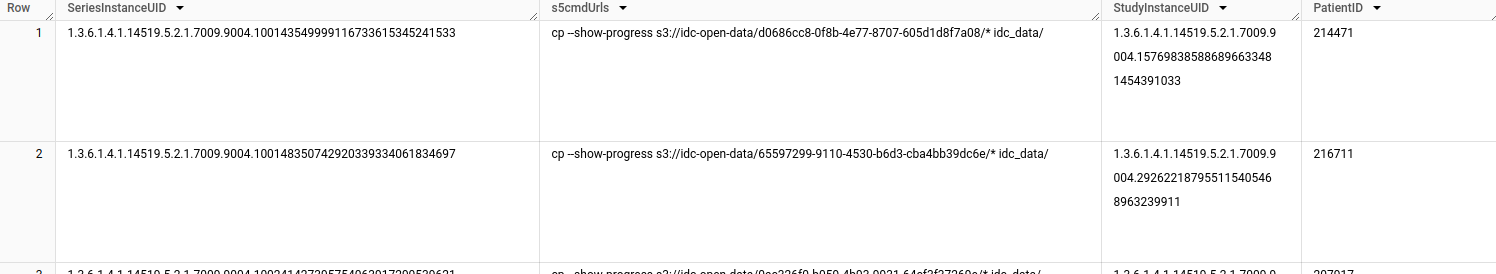
* Run each cell to install the packages and to decompress the segmentation maps, and to download the CT data from IDC, convert to NIfTI, write DICOM Seg and DICOM SR files saved in lz4 compressed format

####**Docker**
* This notebook is saved by default in a way that's amenable to be used on Terra/SB-CGC platforms using Docker
* Running this notebook in a docker container ensures reproduciblity, as we lock the run environment beginning from the base docker image to apt packages and pip packages in the docker image

* Docker images can be found @ https://hub.docker.com/repository/docker/imagingdatacommons/radiomics/tags
* The link to dockerfile along with git commit hash used for building the docker image can be found in one of the layers called 'LABEL'
* We use a python package called Papermill, that can run the notebook with out having to convert it to python script. This allows us maintain one copy of code instead of two.
* To use papermill, download this notebook and tag the cell under 'Parameters for Papermill" as parameters using jupyternotebook or jupyterlab as instructed @ https://papermill.readthedocs.io/en/latest/usage-parameterize.html#designate-parameters-for-a-cell
* A sample papermill command is
<pre>
papermill -p csvFilePath path_to_csv_manifest.csv -p inferenceNiftiFilePath path_to_inference_nifti_files.lz4 dicomsegAndRadiomicsSR_Notebook.ipynb outputdicomsegAndRadiomicsSR_Notebook.ipynb
</pre>




###**Installing Packages**

In [ ]:
%%capture
!sudo apt-get update \
  && apt-get install -y --no-install-recommends \
    build-essential\
    lz4\
    pigz\
    python3-dev\
    unzip\
    wget\
    zip\
  && rm -rf /var/lib/apt/lists/*

In [ ]:
%%capture
!sudo pip3 install --no-cache-dir \
    highdicom==0.21.1\
    ipykernel==6.22.0\
    ipython==8.11.0\
    ipywidgets==8.0.5\
    jupyter==1.0.0\
    matplotlib==3.7.1\
    nibabel==5.1.0\
    pandas==1.5.3\
    papermill==2.4.0\
    p_tqdm==1.4.0\
    pydicom==2.4.1\
    tqdm==4.65.0\
 && pip install --no-cache-dir \
    pyradiomics==3.0.1

In [ ]:
%%capture
!wget "https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip" \
  && unzip "dcm2niix_lnx.zip" \
  && rm "dcm2niix_lnx.zip" \
  && mv dcm2niix /usr/local/bin/dcm2niix

In [ ]:
%%capture
dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
dcmqi_download_path = f"dcmqi-1.2.5-linux.tar.gz"
dcmqi_path = f"dcmqi-1.2.5-linux"

!wget -O $dcmqi_download_path $dcmqi_release_url

!tar -xvf $dcmqi_download_path

!mv $dcmqi_path/bin/* /bin
!rm -r $dcmqi_download_path $dcmqi_path

In [ ]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.2.2/s5cmd_2.2.2_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.2.2_Linux-64bit.tar.gz"
!rm "s5cmd_2.2.2_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd
!rm CHANGELOG.md LICENSE README.md

###**Importing Packages**

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime
from functools import partial
import glob
import highdicom.sr.content as sr_content
from highdicom.sr.enum import GraphicTypeValues, GraphicTypeValues3D
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation
)
from highdicom.sr.value_types import (
    CodedConcept,
    CodeContentItem,
)
import json
import logging
import matplotlib.pyplot as plt
import multiprocessing
import nibabel as nib
import numpy as np
import os
from pathlib import Path
import pandas as pd
import psutil
import pydicom
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes
from pydicom.uid import generate_uid
import radiomics
from radiomics import featureextractor, generalinfo
import random
import re
import shutil
import SimpleITK as sitk
import subprocess
import sys
import time
from time import sleep, asctime, localtime
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

logging.getLogger('pyradiomics').setLevel(logging.CRITICAL)
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)

curr_dir = Path().absolute()
print(asctime(localtime()))
print("\nCurrent directory :{}".format(curr_dir))
print("Python version :", sys.version.split('\n')[0])


Sun Dec  3 19:58:20 2023

Current directory :/content
Python version : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


###**Parameters for Papermill**

In [ ]:
csvFilePath=''
inferenceNiftiFilePath=''

###Environment Variable

In [ ]:
converterType='dcm2niix'

###**For local testing**

In [ ]:
try:
  os.remove(f'{curr_dir}/batch_1.csv')
  os.remove(f'{curr_dir}/inferenceNiftiFiles.tar.lz4')
except OSError:
  pass

!wget https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/notebooks/sampleManifests/batch_1.csv
csvFilePath = glob.glob('*.csv')[0]

#!wget https://github.com/ImagingDataCommons/Cloud-Resources-Workflows/raw/notebooks/sampleManifests/inferenceNiftiFiles.tar.lz4
#Get the file path of the inferenceNiftiFiles
inferenceNiftiFilePath=glob.glob('*.lz4')[0]

--2023-12-03 19:58:20--  https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/notebooks/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5811 (5.7K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>]   5.67K  --.-KB/s    in 0s      

2023-12-03 19:58:20 (62.8 MB/s) - ‘batch_1.csv’ saved [5811/5811]



###Extracting Inference NIFTI files

In [ ]:
try:
  shutil.rmtree(f'output_data')
except OSError:
  pass

#!lz4 -d {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -
!lz4 -d /content/output.tar.lz4 -c | tar --strip-components=0 -xvf-

output_data/
output_data/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/
output_data/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/segmentations.nii.gz


###Reading CSV File containing s5cmd Urls

In [ ]:
start_time = time.time()
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.023697853088378906  seconds


###**Downloading Config for DICOM_SEG conversion and Label maps from TotalSegmentator**

In [ ]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole_slicerAsRef.json')
  os.remove(f'{curr_dir}/map_to_binary.py')
except OSError:
  pass
!wget https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
!wget https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
import map_to_binary

--2023-12-03 19:58:20--  https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/dicomseg_metadata_whole_slicerAsRef.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99157 (97K) [text/plain]
Saving to: ‘dicomseg_metadata_whole_slicerAsRef.json’

dicomseg_metadata_w 100%[===================>]  96.83K  --.-KB/s    in 0.02s   

2023-12-03 19:58:20 (3.96 MB/s) - ‘dicomseg_metadata_whole_slicerAsRef.json’ saved [99157/99157]

--2023-12-03 19:58:20--  https://raw.githubusercontent.com/wasserth/TotalSegmentator/master/totalsegmentator/map_to_binary.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercont

###Functions

In [ ]:
try:
  shutil.rmtree(f'itkimage2segimage')
  shutil.rmtree(f'radiomics')
  shutil.rmtree(f'{converterType}')
  shutil.rmtree(f'structuredReportsDICOM')
  shutil.rmtree(f'structuredReportsJSON')
  shutil.rmtree(f'jsonConfigs')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')
os.mkdir(f'radiomics')
os.mkdir(f'{converterType}')
os.mkdir(f'structuredReportsDICOM')
os.mkdir(f'structuredReportsJSON')
os.mkdir(f'jsonConfigs')

In [ ]:
def download_dicom_data(series_id: str) -> None:
  """
  Download raw DICOM data into "idc_data" folder.

  Args:
  series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
  """

  # Attempt to remove the directory for the series if it exists
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass

  # Access the global dataframe variable
  global cohort_df

  # Get the series data from the dataframe
  gs_file_path = "s5cmd_manifest.txt"
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]

  # Write the URLs to a file
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)

  # Remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt

  # Start a timer for the download
  start_time = time.time()
  print("Copying files from IDC buckets..")

  # Download the files and suppress output
  !s5cmd --no-sign-request --endpoint-url https://s3.amazonaws.com run s5cmd_manifest.txt
  #>> /dev/null

  # Calculate and print elapsed time
  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [ ]:
def convert_dicom_to_nifti(series_id: str) -> None:
  """
  Converts a DICOM series to a NIfTI file.

  Args:
    series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
  """

  # Determine which converter to use based on the converterType variable
  converter = "dcm2niix" if converterType.lower() == "dcm2niix" else "plastimatch"

  # Attempt to remove the directory for the series if it exists
  try:
    shutil.rmtree(f"{converter}/{series_id}")
  except OSError:
    pass

  # Create a new directory for the series
  os.mkdir(f"{converter}/{series_id}")

  print("\n Converting DICOM files to NIfTI \n")

  # Run the appropriate converter command and capture the output
  if converter == "dcm2niix":
    result = subprocess.run(f"dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o {curr_dir}/dcm2niix/{series_id} {curr_dir}/idc_data/", shell=True, capture_output=True, text=True)
    print(result.stdout)
    print("\n Conversion successful")
  else:
    subprocess.run(f"plastimatch convert --input {curr_dir}/idc_data/{series_id} --output-img {curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz", shell=True)


In [ ]:
def dicom_seg_config(series_id: str, series_number: str) -> None:
    """
    Create JSON config file required for DICOM SEG creation with dcmqi

    Args:
        series_id: The DICOM Tag SeriesInstanceUID of the DICOM series to be converted.
        series_number: The DICOM Tag SeriesNumber of the DICOM series to be converted.
    """
    # Open the JSON file and load the data
    with open('dicomseg_metadata_whole_slicerAsRef.json', 'r') as f:
        data = json.load(f)

    # Update the SeriesNumber and SeriesDescription fields
    data['SeriesNumber'] = str(int(series_number)*100)
    data['SeriesDescription'] = f'TotalSegmentator(v1.5.5) Segmentation of Series {series_number}'


    # Attempt to remove the directory for the series if it exists
    try:
      shutil.rmtree(f"jsonConfigs/{series_id}")
    except OSError:
      pass

    # Create a new directory for the series
    os.mkdir(f"jsonConfigs/{series_id}")

    print("\n Creating JSON Config file dcmqi itkimage2image")

    # Write the updated data back to the JSON file
    with open(f"jsonConfigs/{series_id}/{series_id}_dcmqi_config.json", 'w') as f:
        json.dump(data, f, indent=4)
        print("\n JSON Config creation successful")



In [ ]:
totalsegmentator_segments_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/TotalSegmentator%20v1%20SCT%20mapping%20-%20total.csv',index_col=[0], dtype={'SegmentedPropertyTypeModifierCodeSequence.CodeValue': str})
totalsegmentator_radiomics_features_code_mapping_df=pd.read_csv('https://raw.githubusercontent.com/ImagingDataCommons/Cloud-Resources-Workflows/config_fix/configs/TotalSegmentator/radiomicsFeaturesMaps.csv',index_col=[0])
totalsegmentator_radiomics_features_code_mapping_df


,feature,pyradiomics_feature_class,pyradiomics_notes,quantity_CodingSchemeDesignator,quantity_CodeValue,quantity_CodeMeaning,units_CodingSchemeDesignator,units_CodeValue,units_CodeMeaning
0,Elongation,shape,NaN,IBSI,Q3CK,Elongation,UCUM,1,no units
1,Flatness,shape,NaN,IBSI,N17B,Flatness,UCUM,1,no units
2,LeastAxisLength,shape,NaN,IBSI,7J51,Least axis length,UCUM,mm,millimeter
3,MajorAxisLength,shape,NaN,IBSI,TDIC,Major axis length,UCUM,mm,millimeter
4,Maximum3DDiameter,shape,https://pyradiomics.readthedocs.io/en/latest/f...,IBSI,L0JK,Maximum 3D diameter,UCUM,mm,millimeter
5,MeshVolume,shape,NaN,IBSI,RNU0,Volume,UCUM,mm3,cubic millimeter
6,MinorAxisLength,shape,NaN,IBSI,P9VJ,Minor axis length,UCUM,mm,millimeter
7,Sphericity,shape,NaN,IBSI,QCFX,Sphericity,UCUM,1,no units
8,SurfaceArea,shape,Calculated using Marching Cubes,IBSI,C0JK,Surface area,UCUM,mm2,square millimeter
9,SurfaceVolumeRatio,shape,NaN,IBSI,2PR5,Surface to volume ratio,UCUM,/mm,per millimeter


In [ ]:
#set radiomics verbosity
logger = radiomics.logger
logger.setLevel(logging.WARNING)

In [ ]:
def get_radiomics_features(seg_file, img_file, label=None):
    try:
        settings = {}
        #settings["resampledPixelSpacing"] = [3,3,3]
        settings["geometryTolerance"] = 1e-3

        radiomics.setVerbosity(logging.CRITICAL)
        extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

        shape_features_list = totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='shape']['feature'].tolist()
        firstorder_features_list = totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='firstorder']['feature'].tolist()

        # Pass a dictionary to enableFeaturesByName
        extractor.disableAllFeatures()
        enabledFeatures={}
        enabledFeatures['shape']=shape_features_list
        enabledFeatures['firstorder']=firstorder_features_list
        extractor.enableFeaturesByName(**enabledFeatures)

        features = extractor.execute(str(img_file), str(seg_file), label=label)

        cleaned_quant_features = {k.replace("original_", ""): v for k, v in features.items() if k.startswith("original_")}
        cleaned_quant_features = {k: round(float(v), 4) for k, v in cleaned_quant_features.items()}

        suffixes = ("CenterOfMass", "BoundingBox")
        cleaned_general_features = {k.replace("diagnostics_Mask-original_", ""): v for k, v in features.items() if k.endswith(suffixes)}
        cleaned_general_features = {k: v for k, v in cleaned_general_features.items()}
        cleaned_quant_features.update(cleaned_general_features)

    except Exception as e:
        print(f"WARNING: radiomics raised an exception (settings all features to 0): {e}")
        features = {feat: 0 for feat in shape_features_list}
        general_features =  {feat: 0 for feat in general_features}

    return cleaned_quant_features


In [ ]:
def process_mask(seg_file, ct_file, label_id_body_part_df, label):
    mask_stats = get_radiomics_features(seg_file, ct_file, label=label)

    mask_stats = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in mask_stats.items()}
    body_part = label_id_body_part_df.loc[label_id_body_part_df['label_id'] == label]['body_part'].values[0]

    return (body_part, mask_stats)


In [ ]:
def get_radiomics_features_for_all_labels(ct_file: Path, seg_file: Path, file_out: Path):
    label_id_body_part_data = map_to_binary.class_map['total_v1'].items()
    # create a DataFrame from the extracted data
    label_id_body_part_df = pd.DataFrame(label_id_body_part_data, columns=['label_id', 'body_part'])
    stats = {}
    labels = [int(x) for x in np.unique(nib.load(seg_file).get_fdata()).tolist() if x != 0]
    with multiprocessing.Pool() as pool:
        func = partial(process_mask, seg_file, ct_file, label_id_body_part_df)
        results = list(tqdm(pool.imap(func, labels), total=len(labels)))
    for body_part, mask_stats in results:
        if any(v != 0 for v in mask_stats.values()):
            stats[body_part] = mask_stats
    with open(file_out, "w") as f:
        json.dump(stats, f, indent=4)


In [ ]:
def remove_directories_without_nii_files(path):
    for dirpath, dirnames, filenames in os.walk(path, topdown=False):
        if dirpath != path and not any(filename.endswith('.nii.lz4') for filename in filenames):
            try:
                os.rmdir(dirpath)
            except OSError as e:
                print(f"Error: Failed to remove directory {dirpath}: {e}")

In [ ]:
#removing empty directories
remove_directories_without_nii_files(os.path.join(curr_dir,'output_data/'))

Error: Failed to remove directory /content/output_data/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533: [Errno 39] Directory not empty: '/content/output_data/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533'


In [ ]:
def check_dicom_seg_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('itkimage2segimage_error_file.txt', 'a') as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")
        return True
    return False

In [ ]:
def check_radiomics_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('radiomics_error_file.txt', 'a') as f:
            f.write(f"Error: Radiomics Feature extraction failed for series {series_id}\n")
        return True
    return False

In [ ]:
def order_dicom_files_image_position(dcm_directory):
  """
  Orders the dicom files according to image position and orientation.

  Arguments:
    dcm_directory : input directory of dcm files to put in order

  Outputs:
    files_sorted   : dcm files in sorted order
    sop_all_sorted : the SOPInstanceUIDs in sorted order
    pos_all_sorted : the image position in sorted order

  """
  files = [os.path.join(dcm_directory,f) for f in os.listdir(dcm_directory)]

  num_files = len(files)

  pos_all = []
  sop_all = []

  for n in range(0,num_files):
    # read dcm file
    filename = files[n]
    ds = dcmread(filename)

    # get ImageOrientation (0020, 0037)
    # ImageOrientation = ds['0x0020','0x0037'].value
    ImageOrientation = ds.ImageOrientationPatient

    # get ImagePositionPatient (0020, 0032)
    # ImagePositionPatient = ds['0x0020','0x0032'].value
    ImagePositionPatient = ds.ImagePositionPatient

    # calculate z value
    x_vector = ImageOrientation[0:3]
    y_vector = ImageOrientation[3:]
    z_vector = np.cross(x_vector,y_vector)

    # multiple z_vector by ImagePositionPatient
    pos = np.dot(z_vector,ImagePositionPatient)
    pos_all.append(pos)

    # get the SOPInstanceUID
    # sop = ds['0x0008', '0x0018'].value
    sop = ds.SOPInstanceUID
    sop_all.append(sop)


  #----- order the SOPInstanceUID/files by z value ----#

  sorted_ind = np.argsort(pos_all)
  pos_all_sorted = np.array(pos_all)[sorted_ind.astype(int)]
  sop_all_sorted = np.array(sop_all)[sorted_ind.astype(int)]
  files_sorted = np.array(files)[sorted_ind.astype(int)]

  return files_sorted, sop_all_sorted, pos_all_sorted

In [ ]:
def create_structured_report_metajson_for_features(SeriesInstanceUID,
                                                         SOPInstanceUID_seg,
                                                         seg_file,
                                                         dcm_directory,
                                                         segments_code_mapping_df,
                                                         features_code_mapping_df,
                                                         radiomics_features,
                                                         ):

  """Function that creates the metajson necessary for the creation of a
  structured report from a pandas dataframe of label names and features for
  each.

  Inputs:
    SeriesInstanceUID               : SeriesInstanceUID of the corresponding CT
                                      file
    SOPInstanceUID_seg              : SOPInstanceUID of the corresponding SEG file
    seg_file                        : filename of SEG DCM file
    dcm_directory                   : ct directory that will be sorted in
                                      terms of axial ordering according to the
                                      ImagePositionPatient and ImageOrientation
                                      fields
    segments_code_mapping_df        : dataframe that holds the names of the
                                      segments and the associated code values etc.
    features_code_mapping_df        : dataframe that holds the names of the
                                      features and the associated code values etc.
    df_features                     : a pandas dataframe holding the segments and a
                                      set of 3D shape features for each

  Outputs:
    Returns the metajson for the structured report that will then be used by
    dcmqi tid1500writer to create a structured report
  """
  series_number = str(cohort_df[cohort_df['SeriesInstanceUID']==series_id]['seriesNumber'].values[0])
  # --- Get the version number for the pyradiomics package --- #

  pyradiomics_version_number = str(radiomics.__version__)

  # --- Sort the dcm files first according to --- #
  # --- ImagePositionPatient and ImageOrientation --- #

  files_sorted, sop_all_sorted, pos_all_sorted = order_dicom_files_image_position(dcm_directory)
  files_sorted = [os.path.basename(f) for f in files_sorted]

  # --- Create the header for the json --- #

  inputMetadata = {}
  inputMetadata["@schema"]= "https://raw.githubusercontent.com/qiicr/dcmqi/master/doc/schemas/sr-tid1500-schema.json#"
  inputMetadata["SeriesDescription"] = "TotalSegmentator(v1.5.5) "+features_code_mapping_df['pyradiomics_feature_class'].iloc[0]+ " Measurements of series "+str(series_number)
  inputMetadata["SeriesNumber"] = str(1+int(series_number)*100)
  inputMetadata["InstanceNumber"] = "1"

  inputMetadata["compositeContext"] = [seg_file] # not full path

  inputMetadata["imageLibrary"] = files_sorted # not full path
  inputMetadata["observerContext"] = {
                      "ObserverType": "DEVICE",
                      "DeviceObserverName": "pyradiomics",
                      "DeviceObserverModelName": pyradiomics_version_number
                    }

  inputMetadata["VerificationFlag"]  = "UNVERIFIED"
  inputMetadata["CompletionFlag"] =  "COMPLETE"
  inputMetadata["activitySession"] = "1"
  inputMetadata["timePoint"] = "1"

  # ------------------------------------------------------------------------- #
  # --- Create the measurement_dict for each segment - holds all features --- #

  measurement = []

  # --- Now create the dict for all features and all segments --- #

  # --- Loop over the number of segments --- #

  # number of rows in the df_features
  num_segments = radiomics_features.shape[0]
  print(num_segments)

  # Array of dictionaries - one dictionary for each segment
  measurement_across_segments_combined = []

  for segment_id in range(0,num_segments):

    ReferencedSegment = int(radiomics_features['seg_segment_number'].values[segment_id]) # referencedsegment must be an integer according to the schema.
    FindingSite = radiomics_features['body_part'].values[segment_id]

    # --- Create the dict for the Measurements group --- #
    TrackingIdentifier = "Measurements group " + str(ReferencedSegment)

    segment_row = segments_code_mapping_df[segments_code_mapping_df["Structure"] == FindingSite]


    # Inside the loop for each segment
    my_dict = {
      "TrackingIdentifier": str(TrackingIdentifier),
      "ReferencedSegment": int(ReferencedSegment),
      "SourceSeriesForImageSegmentation": str(SeriesInstanceUID),
      "segmentationSOPInstanceUID": str(SOPInstanceUID_seg),
      "Finding": {
        "CodeValue": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeValue"].iloc[0]),
        "CodingSchemeDesignator": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodingSchemeDesignator"].iloc[0]),
        "CodeMeaning": str(segment_row["SegmentedPropertyCategoryCodeSequence.CodeMeaning"].iloc[0]),
      },
      "FindingSite": {
        "CodeValue": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeValue"].iloc[0]),
        "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeCodeSequence.CodingSchemeDesignator"].iloc[0]),
        "CodeMeaning": str(segment_row["SegmentedPropertyTypeCodeSequence.CodeMeaning"].iloc[0]),
      }
    }

    laterality_dict = {
      "CodeValue": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeValue"].iloc[0]),
      "CodingSchemeDesignator": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodingSchemeDesignator"].iloc[0]),
      "CodeMeaning": str(segment_row["SegmentedPropertyTypeModifierCodeSequence.CodeMeaning"].iloc[0])
    }

    # Check if the laterality dictionary is empty
    #if all(laterality_dict.values()) and not any(pd.isna(list(laterality_dict.values()))):
     # my_dict["Laterality"] = laterality_dict

    #Append the remaining code after creating the measurement_across_segments_combined array
    #Check if the laterality dictionary is empty or contains NaN values
    if laterality_dict and not any(value == 'nan' or pd.isna(value) for value in laterality_dict.values()):
      my_dict["Laterality"] = laterality_dict

    measurement = []
    # number of features - number of columns in df_features - 2 (label_name and ReferencedSegment)
    num_values = len(radiomics_features.columns)-2

    #feature_list = radiomics_features.columns[2:] # remove first two
    feature_list = features_code_mapping_df.feature.to_list()

    # For each measurement per region segment
    for n in range(0,len(feature_list)):
      measurement_dict = {}
      row = radiomics_features.loc[radiomics_features['body_part'] == FindingSite]
      feature_row = features_code_mapping_df.loc[features_code_mapping_df["feature"] == feature_list[n]]
      value = str(np.round(row[feature_list[n]].values[0],3))
      measurement_dict["value"] = value
      measurement_dict["quantity"] = {}
      measurement_dict["quantity"]["CodeValue"] = str(feature_row["quantity_CodeValue"].values[0])
      measurement_dict["quantity"]["CodingSchemeDesignator"] = str(feature_row["quantity_CodingSchemeDesignator"].values[0])
      measurement_dict["quantity"]["CodeMeaning"] = str(feature_row["quantity_CodeMeaning"].values[0])
      measurement_dict["units"] = {}
      measurement_dict["units"]["CodeValue"] = str(feature_row["units_CodeValue"].values[0])
      measurement_dict["units"]["CodingSchemeDesignator"] = str(feature_row["units_CodingSchemeDesignator"].values[0])
      measurement_dict["units"]["CodeMeaning"] = str(feature_row["units_CodeMeaning"].values[0])
      measurement_dict["measurementAlgorithmIdentification"] = {}
      measurement_dict["measurementAlgorithmIdentification"]["AlgorithmName"] = "pyradiomics"
      measurement_dict["measurementAlgorithmIdentification"]["AlgorithmVersion"] = str(pyradiomics_version_number)
      measurement.append(measurement_dict)

    measurement_combined_dict = {}
    measurement_combined_dict['measurementItems'] = measurement # measurement is an array of dictionaries

    output_dict_one_segment = {**my_dict, **measurement_combined_dict}

    # append to array for all segments

    measurement_across_segments_combined.append(output_dict_one_segment)

  # --- Add the measurement data --- #

  inputMetadata["Measurements"] = {}
  inputMetadata["Measurements"] = measurement_across_segments_combined
  feature_type = features_code_mapping_df['pyradiomics_feature_class'].iloc[0]
  sr_json_path=f'{curr_dir}/structuredReportsJSON/{series_id}/{series_id}_{feature_type}_sr.json'
  sr_path=f'{curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_{feature_type}_sr.dcm'
  pred_dicomseg_path=f'{curr_dir}/itkimage2segimage/{series_id}'

  with open(sr_json_path, 'w') as f:
    json.dump(inputMetadata, f, indent=2)
    print (f'wrote out json for {feature_type} features')

  inputImageLibraryDirectory = dcm_directory
  # outputDICOM = sr_json_path
  outputDICOM = sr_path
  # the name of the folder where the seg files are located
  inputCompositeContextDirectory = pred_dicomseg_path
  inputMetadata_json = sr_json_path

  print ('inputImageLibraryDirectory: ' + str(inputImageLibraryDirectory))
  print ('outputDICOM: ' + str(outputDICOM))
  print ('inputCompositeContextDirectory: ' + str(inputCompositeContextDirectory))
  print ('inputMetadata_json: ' + str(inputMetadata_json))
  !tid1500writer --inputImageLibraryDirectory $inputImageLibraryDirectory \
                --outputDICOM $outputDICOM  \
                --inputCompositeContextDirectory $inputCompositeContextDirectory \
                --inputMetadata $sr_json_path
  print (f'wrote out SR for {feature_type} radiomics features\n')



In [ ]:
def initialize_itkimage2segimageAndRadiomics_directories(series_id: str):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
        shutil.rmtree(f'radiomics/{series_id}')
        shutil.rmtree(f'structuredReportsDICOM/{series_id}')
        shutil.rmtree(f'structuredReportsJSON/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')
        os.mkdir(f'radiomics/{series_id}')
        os.mkdir(f'structuredReportsDICOM/{series_id}')
        os.mkdir(f'structuredReportsJSON/{series_id}')

In [ ]:
def create_dicom_seg_dcmqi(series_id:str):

      print('\n Generating DICOM SEG File')
      #Get Inference NIFTI file path
      #inference_nifti_filename_path = os.path.join(curr_dir,'output_data', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'output_data', series_id, 'segmentations.nii.gz')

    #  try:
    #    os.remove(inference_nifti_filename)
    #  except OSError:
    #    pass
    #  !lz4 -d --rm {inference_nifti_filename_path}

      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/jsonConfigs/{series_id}/{series_id}_dcmqi_config.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("\n DICOM SEG created in %g seconds.\n"%itkimage2segimage_time)



In [ ]:
def calculate_radiomics_features_all_labels(series_id:str):

      inference_nifti_filename = os.path.join(curr_dir,'output_data', series_id,'segmentations.nii.gz')
      ct_series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      ct_nifti_files = os.listdir(ct_series_id_folder_path)
      # Get the first (and only) file in the list
      ct_nifti_filename = ct_nifti_files[0]
      # Get the full path of the file
      ct_nifti_filename_path = os.path.join(ct_series_id_folder_path, ct_nifti_filename)

      radiomics_output_filename= os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json')

      start_time = time.time()
      get_radiomics_features_for_all_labels(ct_nifti_filename_path, inference_nifti_filename, radiomics_output_filename)
      radiomics_time = time.time() - start_time
      print("Radiomics Features Calculation Done in %g seconds."%radiomics_time)

In [ ]:
def post_processing_radiomics(series_id):
      # Load JSON, rename columns, reset index, and merge with label_id_body_part_df
      radiomics_features = pd.merge(
          pd.read_json(os.path.join(curr_dir, 'radiomics', series_id, f'{series_id}_radiomics.json'), orient='index')
          .rename(columns=lambda x: x.split('_')[-1])
          .reset_index()
          .rename(columns={'index': 'body_part'}),
          pd.DataFrame(map_to_binary.class_map['total_v1'].items(), columns=['label_id', 'body_part']),
          on='body_part'
      )

      # Sort 'label_id', create 'seg_segment_number', and reorder columns
      radiomics_features = radiomics_features.assign(
          label_id=radiomics_features['label_id'].astype(int).sort_values(),
          seg_segment_number=range(1, len(radiomics_features) + 1)
      )[['body_part', 'seg_segment_number', 'label_id'] + [col for col in radiomics_features.columns if col not in ['body_part', 'seg_segment_number', 'label_id']]]

      return radiomics_features

In [ ]:
def itkimage2segimageAndRadiomics(series_id, series_number):

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """

      initialize_itkimage2segimageAndRadiomics_directories(series_id)

      print("Processing series: "+series_id)

      download_dicom_data(series_id)

      convert_dicom_to_nifti(series_id)

      dicom_seg_config(series_id, series_number)

      create_dicom_seg_dcmqi(series_id)

      check_dicom_seg_errors(series_id)

      calculate_radiomics_features_all_labels(series_id)

      check_radiomics_errors(series_id)

      start_time = time.time()

      radiomics_features =  post_processing_radiomics(series_id)

      radiomics_features.to_csv('a.csv')

      seg_dcm=dcmread(f'{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm')
      SOPInstanceUID_seg=seg_dcm.file_meta['0x0002', '0x0003'].value

      seg_file=f'{series_id}.dcm'
      dcm_directory=f'{curr_dir}/idc_data'


      segments_code_mapping_df= totalsegmentator_segments_code_mapping_df
      shape_features_code_mapping_df=totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='shape']
      first_order_features_code_mapping_df=totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='firstorder']
      general_features_code_mapping_df=totalsegmentator_radiomics_features_code_mapping_df[totalsegmentator_radiomics_features_code_mapping_df['pyradiomics_feature_class']=='general']

      create_structured_report_metajson_for_features( series_id,
                                                            SOPInstanceUID_seg,
                                                            seg_file,
                                                            dcm_directory,
                                                            segments_code_mapping_df,
                                                            shape_features_code_mapping_df,
                                                            radiomics_features,
                                                            )
      create_structured_report_metajson_for_features( series_id,
                                                            SOPInstanceUID_seg,
                                                            seg_file,
                                                            dcm_directory,
                                                            segments_code_mapping_df,
                                                            first_order_features_code_mapping_df,
                                                            radiomics_features,
                                                            )

      structuredReportsGenerationTime = time.time() - start_time
      print("Structured Reports Generated in %g seconds \n."%structuredReportsGenerationTime)


      start_time = time.time()
      !lz4 --rm {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      !lz4 --rm {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json  {curr_dir}/radiomics/{series_id}/{series_id}_radiomics.json.lz4
      !lz4 --rm {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_shape_sr.dcm  {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_shape_sr.dcm.lz4
      !lz4 --rm {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_firstorder_sr.dcm  {curr_dir}/structuredReportsDICOM/{series_id}/{series_id}_firstorder_sr.dcm.lz4
      !lz4 --rm {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_shape_sr.json  {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_shape_sr.json.lz4
      !lz4 --rm {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_firstorder_sr.json  {curr_dir}/structuredReportsJSON/{series_id}/{series_id}_firstorder_sr.json.lz4

      archiving_time = time.time() - start_time

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]})
      log['itkimage2segimage_time']=0 #itkimage2segimage_time
      log['archiving_time'] = archiving_time
      log['radiomics_time']=0 #radiomics_time
      log['structuredReportsGenerationTime']=structuredReportsGenerationTime

#      !rm -r {curr_dir}/Inference/{series_id}
#      !rm -r {curr_dir}/idc_data
#      !rm -r {curr_dir}/{converterType}/{series_id}

      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True
        self.working_disk_path = self.get_working_disk_path()

    def get_working_disk_path(self):
        partitions = psutil.disk_partitions()
        for partition in partitions:
            if partition.mountpoint == '/':
                return '/'
            elif '/cromwell_root' in partition.mountpoint:
                return '/cromwell_root'
        return '/'  # Default to root directory if no specific path is found

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb = []
        disk_usage_all = []
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_usage = psutil.disk_usage(self.working_disk_path)
            disk_used = disk_usage.used / 1024 / 1024 / 1024
            disk_total = disk_usage.total / 1024 / 1024 / 1024
            ram_total_mb = ram.total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time() - start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total


###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533
Copying files from IDC buckets..
100.00%  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  91.10 MB / 91.10 MB (60.82 MB/s) 1.7s (173/173)
Done in 2.04812 seconds.

 Converting DICOM files to NIfTI 

Chris Rorden's dcm2niiX version v1.0.20230411  (JP2:OpenJPEG) (JP-LS:CharLS) GCC8.4.0 x86-64 (64-bit Linux)
Found 173 DICOM file(s)
Convert 173 DICOM as /content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_2,OPA,TO,AQUL4,FC10,419.9,2,120,75,na,na_20010102000000_3 (512x512x173x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_2,OPA,TO,AQUL4,FC10,419.9,2,120,75,na,na_20010102000000_3.nii"
Conversion required 9.973291 seconds (0.406140 for core code).



100%|██████████| 78/78 [15:52<00:00, 12.21s/it]


Radiomics Features Calculation Done in 955.035 seconds.
78
wrote out json for shape features
inputImageLibraryDirectory: /content/idc_data
outputDICOM: /content/structuredReportsDICOM/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_shape_sr.dcm
inputCompositeContextDirectory: /content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533
inputMetadata_json: /content/structuredReportsJSON/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_shape_sr.json
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Total measurement groups: 78
Adding to compositeContext: 1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533.dcm
Composite Context has been initialized
SR saved!
wrote out SR for shape radiomics features

78
wrote out json for firstorder features
inputImageL

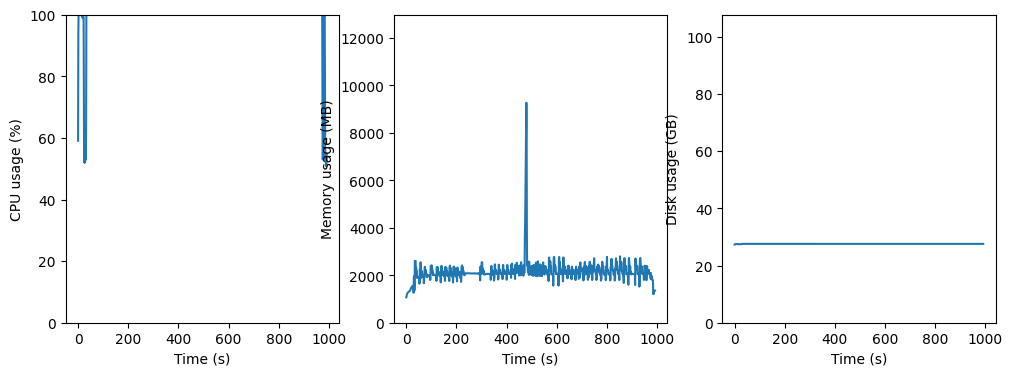

In [ ]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time','radiomics_time',
                                      'archiving_time','structuredReportsGenerationTime', 'cpu_usage','ram_usage_mb', 'ram_total_mb',
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'output_data'):
    # for series_id in ['1.3.6.1.4.1.14519.5.2.1.7009.9004.100241427395754063917290539621']:
        series_number = str(cohort_df[cohort_df['SeriesInstanceUID']==series_id]['seriesNumber'].values[0])
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimageAndRadiomics, series_id, series_number)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()

                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]

                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4))

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/dicomsegAndRadiomicsSR_DICOMsegFiles.tar.lz4')
  os.remove(f'{curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4')
  os.remove(f'{curr_dir}/structuredReportsDICOM.tar.lz4')
  os.remove(f'{curr_dir}/structuredReportsJSON.tar.lz4')

except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/dicomsegAndRadiomicsSR_DICOMsegFiles.tar.lz4
!tar cvf - {curr_dir}/radiomics | lz4 > {curr_dir}/pyradiomicsRadiomicsFeatures.tar.lz4
!tar cvf - {curr_dir}/structuredReportsDICOM | lz4 > {curr_dir}/structuredReportsDICOM.tar.lz4
!tar cvf - {curr_dir}/structuredReportsJSON | lz4 > {curr_dir}/structuredReportsJSON.tar.lz4

output_archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533.dcm.lz4
tar: Removing leading `/' from member names
/content/radiomics/
/content/radiomics/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/
/content/radiomics/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_radiomics.json.lz4
tar: Removing leading `/' from member names
/content/structuredReportsDICOM/
/content/structuredReportsDICOM/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/
/content/structuredReportsDICOM/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533/1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533_firstorder_sr.dc

###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('dicomsegAndRadiomicsSR_UsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv dicomsegAndRadiomicsSR_UsageMetrics.lz4
runtime_stats

Compressed 39889 bytes into 6802 bytes ==> 17.05%


,SeriesInstanceUID,itkimage2segimage_time,radiomics_time,archiving_time,structuredReportsGenerationTime,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,output_archiving_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999...,0,0,0.728151,7.489484,"[[[59.1, 94.0, 100.0, 100.0, 100.0, 100.0, 100...","[[[1070.06640625, 1112.94921875, 1181.4765625,...",[12982.625],"[[[27.32888412475586, 27.329479217529297, 27.3...",107.715084,0.431317
